In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# User details and dataset file paths
user_details_path = '/content/drive/My Drive/IR_Project/user_details.csv'
gym_dataset_path = '/content/drive/My Drive/IR_Project/TrainingDataset.csv'
unique_workout_plan_path = '/content/drive/My Drive/IR_Project/unique_workout_plan.csv'

# Load the workout plans dataset
workout_plans_df = pd.read_csv(unique_workout_plan_path)

# Combine the exercise columns into one text field for vectorization
exercise_columns = [f'{i}' for i in range(1, 8)]  # Assuming exercise columns are named Exercise1, Exercise2, ..., Exercise7
workout_plans_df['All_Exercises'] = workout_plans_df[exercise_columns].apply(lambda x: ' '.join(x.dropna()), axis=1)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

print("Welcome to the Training Program Recommender System!")
print("Your journey towards a personalized fitness experience begins here.\n")

def calculate_bmi(height, weight):
    return weight / (height ** 2)

def register(users_df):
    username = input("Enter a new username: ")
    if username in users_df['Username'].values:
        print("Username already exists. Please try a different username.")
        return users_df

    password = input("Enter password: ")
    height = float(input("Enter your height in meters: "))
    weight = float(input("Enter your weight in kilograms: "))
    bmi = calculate_bmi(height, weight)

    users_df = users_df.append({
        'Username': username,
        'Password': password,
        'BMI': bmi,
    }, ignore_index=True)

    users_df.to_csv(user_details_path, index=False)
    print(f"Registration successful. Your BMI is {bmi:.1f}. You can now login with your new credentials.\n")
    return False, users_df

def login(users_df):
    username = input("Enter your username: ")
    password = input("Enter your password: ")

    if not ((users_df['Username'] == username) & (users_df['Password'] == password)).any():
        print("Invalid username or password.")
        return False
    print("Login successful. Welcome back!\n")
    return True

def display_muscle_groups():
    unique_muscle_groups = sorted(set(workout_plans_df['Muscle Groups'].str.split(', ').sum()))
    print("Select up to two muscle groups you want to focus on:")
    for i, group in enumerate(unique_muscle_groups, start=1):
        print(f"{i}. {group}")
    choices = input("Enter your choices (names or numbers separated by space, e.g., 1 Abdominals): ").split(maxsplit=2)

    selected_muscle_groups = []
    for choice in choices:
        try:
            index = int(choice) - 1
            if 0 <= index < len(unique_muscle_groups):
                selected_muscle_groups.append(unique_muscle_groups[index])
        except ValueError:
            if choice in unique_muscle_groups:
                selected_muscle_groups.append(choice)

    return selected_muscle_groups[:2]

def prepare_data_for_model():
    X = tfidf_vectorizer.fit_transform(workout_plans_df['All_Exercises'].values.astype('U'))
    y = workout_plans_df['Muscle Groups']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def recommend_workouts(selected_muscle_groups, X_train, y_train, X_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    recommendations = pd.DataFrame()
    for group in selected_muscle_groups:
        sample_description = ' '.join(workout_plans_df[workout_plans_df['Muscle Groups'].str.contains(group, na=False)]['All_Exercises'].iloc[0])
        sample_transformed = tfidf_vectorizer.transform([sample_description])
        similarity_scores = cosine_similarity(sample_transformed, X_test).flatten()
        recommended_indices = np.argsort(similarity_scores)[-3:]
        recommendations = recommendations.append(workout_plans_df.iloc[recommended_indices].drop_duplicates())

    return recommendations

def get_user_ratings(recommendations):
    ratings = []
    for index, row in recommendations.iterrows():
        print(f"\nWorkout ID: {row['MID']}\nMuscle Groups: {row['Muscle Groups']}\nExercises: {row['All_Exercises']}\n")
        rating = int(input("Please rate this workout plan on a scale of 1-10: "))
        ratings.append((index, rating))
    return ratings

def refine_recommendations(bad_ratings, X_train, y_train, X_test):
    refined_recommendations = pd.DataFrame()
    for index, rating in bad_ratings:
        current_group = workout_plans_df.loc[index, 'Muscle Groups']
        refined_recommendations = refined_recommendations.append(recommend_workouts([current_group], X_train, y_train, X_test))
    return refined_recommendations.drop_duplicates()

def calculate_evaluation_metrics(ratings):
    # Assuming ratings 6 or above are 'relevant' and below 6 are 'not relevant'
    true_positives = sum(1 for _, rating in ratings if rating >= 6)
    total_predictions = len(ratings)  # Total number of recommendations made

    # Since we don't have true negatives in this setup, we'll focus on precision and recall only
    precision = true_positives / total_predictions if total_predictions else 0
    recall = true_positives / total_predictions if total_predictions else 0  # Assuming all relevant items were recommended

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    print(f"\nEvaluation Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

def main():
    users_df = pd.read_csv(user_details_path) if os.path.exists(user_details_path) else pd.DataFrame(columns=['Username', 'Password', 'BMI'])

    action = input("Do you want to (L)ogin or (R)egister? ").upper()
    if action == 'R':
        _, users_df = register(users_df)
    elif action == 'L' and not login(users_df):
        return

    selected_muscle_groups = display_muscle_groups()
    X_train, X_test, y_train, y_test = prepare_data_for_model()
    recommended_workouts = recommend_workouts(selected_muscle_groups, X_train, y_train, X_test)


    print("\nBased on your selected muscle groups, here are some recommended workouts for you:")
    print(recommended_workouts[['MID', 'Muscle Groups', 'All_Exercises']])
    ratings = get_user_ratings(recommended_workouts)

    bad_ratings = [rating for rating in ratings if rating[1] < 6]
    if bad_ratings:
        refined_recommendations = refine_recommendations(bad_ratings, X_train, y_train, X_test)
        print("\nBased on your feedback, here are some refined workout plans for you:")
        print(refined_recommendations[['MID', 'Muscle Groups', 'All_Exercises']])
    else:
        print("\nThank you for your feedback. We're glad you found the recommendations helpful!")

    calculate_evaluation_metrics(ratings)

if __name__ == "__main__":
    main()


Welcome to the Training Program Recommender System!
Your journey towards a personalized fitness experience begins here.

Do you want to (L)ogin or (R)egister? L
Enter your username: Dev
Enter your password: Thakkar
Login successful. Welcome back!

Select up to two muscle groups you want to focus on:
1. Abdominals
2. Abductors
3. Adductors
4. Biceps
5. Calves
6. Chest
7. Forearms
8. Glutes
9. Hamstrings
10. Lats
11. Lower Back
12. Middle Back
13. Neck
14. Quadriceps
15. Shoulders
16. Traps
17. Triceps
Enter your choices (names or numbers separated by space, e.g., 1 Abdominals): Back Biceps


<ipython-input-3-113f6cfb2c0f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(workout_plans_df.iloc[recommended_indices].drop_duplicates())



Based on your selected muscle groups, here are some recommended workouts for you:
     MID      Muscle Groups                                      All_Exercises
203  204       Calves, Lats  AM Wide-Grip Pull-Down Weighted donkey calf ra...
205  206  Quadriceps, Traps  Standing dumbbell shrug Smith machine upright ...
599  600       Lats, Glutes  UN Glute Bridge Holman Right Arm Weighted Half...

Workout ID: 204
Muscle Groups: Calves, Lats
Exercises: AM Wide-Grip Pull-Down Weighted donkey calf raise Machine seated calf raise Shotgun row FYR Bent-Over Dumbbell Row Standing Dumbbell Calf Raise

Please rate this workout plan on a scale of 1-10: 9

Workout ID: 206
Muscle Groups: Quadriceps, Traps
Exercises: Standing dumbbell shrug Smith machine upright row Speed skater Smith machine behind-the-back shrug Clean Pull UN Barbell Box Squat

Please rate this workout plan on a scale of 1-10: 3

Workout ID: 600
Muscle Groups: Lats, Glutes
Exercises: UN Glute Bridge Holman Right Arm Weighted Half 

<ipython-input-3-113f6cfb2c0f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(workout_plans_df.iloc[recommended_indices].drop_duplicates())
<ipython-input-3-113f6cfb2c0f>:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  refined_recommendations = refined_recommendations.append(recommend_workouts([current_group], X_train, y_train, X_test))
<ipython-input-3-113f6cfb2c0f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(workout_plans_df.iloc[recommended_indices].drop_duplicates())
<ipython-input-3-113f6cfb2c0f>:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

Training Model

Accuracy: 0.52
Precision: 0.50
Recall: 0.52
F1 Score: 0.51
Average Cosine Similarity: 0.09160347214012998
Maximum Cosine Similarity: 0.915706994348678 (between plans at indices 2144 and 2983)


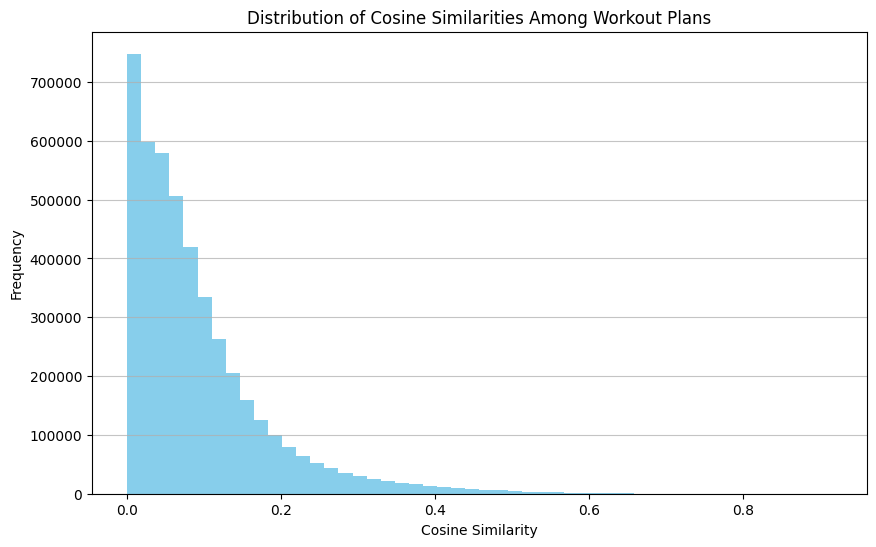

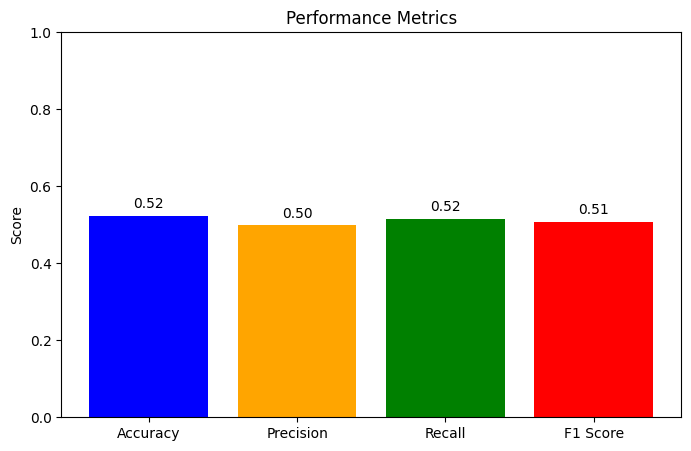

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the updated dataset with the 'Effective' column
dataset_path = '/content/drive/My Drive/IR_Project/updated_unique_workout_plan.csv'
data = pd.read_csv(dataset_path)

# Combine exercises into one text field
data['All_Exercises'] = data[['1', '2', '3', '4', '5', '6', '7']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Vectorize the combined exercises text
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(data['All_Exercises'].values.astype('U'))

# Labels
y = data['Effective']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


cosine_sim_matrix = cosine_similarity(X, X)

# Calculate the average cosine similarity
average_similarity = cosine_sim_matrix.mean()

# Find the most similar pair of workout plans (ignoring self-similarity)
np.fill_diagonal(cosine_sim_matrix, 0)
max_similarity = np.max(cosine_sim_matrix)
most_similar_pair_indices = np.where(cosine_sim_matrix == max_similarity)
index1, index2 = most_similar_pair_indices[0][0], most_similar_pair_indices[1][0]

print(f"Average Cosine Similarity: {average_similarity}")
print(f"Maximum Cosine Similarity: {max_similarity} (between plans at indices {index1} and {index2})")

import matplotlib.pyplot as plt

# Histogram of Cosine Similarities (excluding self-similarities which were set to 0)
cosine_similarities = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarities, bins=50, color='skyblue')
plt.title('Distribution of Cosine Similarities Among Workout Plans')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Bar Chart for Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
plt.show()




In [ ]:
import pandas as pd

# Load the datasets
training_dataset_df = pd.read_csv('/content/drive/My Drive/IR_Project/TrainingDataset.csv')
workout_plans_df = pd.read_csv('/content/drive/My Drive/IR_Project/updated_unique_workout_plan.csv')

# Create a lookup table for exercise titles to S.No
exercise_id_lookup = training_dataset_df.set_index('Title')['S.No'].to_dict()

# Function to replace exercise titles in workout plans with their S.No
def map_exercises_to_ids(workout_series, lookup_table):
    # Replace each exercise title in the series with its S.No using the lookup table
    # If an exercise title is not found in the lookup table, it will be replaced with NaN
    return workout_series.apply(lambda x: lookup_table.get(x, float('nan')))

# Apply the mapping function to each exercise column in the workout plans dataset
for col in ['1', '2', '3', '4', '5', '6', '7']:
    workout_plans_df[col] = map_exercises_to_ids(workout_plans_df[col], exercise_id_lookup)

# Now, the workout plans dataset contains S.No instead of exercise titles
# Display the modified workout plans dataset
print(workout_plans_df.head())

   MID        Muscle Groups     1     2     3     4     5     6       7  \
0    1        Chest, Glutes  1243  1095  1230  1129  1013  1210   970.0   
1    2  Middle Back, Biceps  1633   811   727   794  1701  1691     NaN   
2    3     Traps, Shoulders  1780  1757  1760  2440  2597  2503  2606.0   
3    4     Adductors, Chest  1080  1093  1141   678   662   699   938.0   
4    5      Lats, Adductors   694  1411   675   678  1511  1449     NaN   

   Unnamed: 9  Effective  
0         NaN          0  
1         NaN          1  
2         NaN          0  
3         NaN          0  
4         NaN          0  


In [ ]:
import pandas as pd

# Load the datasets
# Replace these paths with the actual paths to your files
training_dataset_path = '/content/drive/My Drive/IR_Project/TrainingDataset.csv'
workout_plans_path = '/content/drive/My Drive/IR_Project/updated_unique_workout_plan.csv'

training_dataset_df = pd.read_csv(training_dataset_path)
workout_plans_df = pd.read_csv(workout_plans_path)

# Create a lookup table mapping exercise titles to S.No
exercise_id_lookup = training_dataset_df.set_index('Title')['S.No'].to_dict()

# Function to map exercise titles in a workout plan to their corresponding S.No
def replace_exercise_with_id(exercise_name):
    return exercise_id_lookup.get(exercise_name, None)

# Apply the mapping to each exercise column in the workout plans dataset
for col in workout_plans_df.columns[2:]:  # Assuming first two columns are 'MID' and 'Muscle Groups'
    workout_plans_df[col] = workout_plans_df[col].apply(replace_exercise_with_id)

# Save the transformed dataset to a new CSV file
transformed_dataset_path = '/content/drive/My Drive/IR_Project/transformed_workout_plan.csv'
workout_plans_df.to_csv(transformed_dataset_path, index=False)

print("Dataset transformation complete. Transformed dataset saved to:", transformed_dataset_path)


Dataset transformation complete. Transformed dataset saved to: /content/drive/My Drive/IR_Project/transformed_workout_plan.csv


Epoch 1/10
38/38 [==============================] - 9s 118ms/step - loss: 6.6401 - accuracy: 0.6275 - val_loss: 3.8004 - val_accuracy: 0.6867
Epoch 2/10
38/38 [==============================] - 2s 51ms/step - loss: 2.8250 - accuracy: 0.6667 - val_loss: 2.8923 - val_accuracy: 0.6867
Epoch 3/10
38/38 [==============================] - 2s 62ms/step - loss: 2.3879 - accuracy: 0.6667 - val_loss: 2.9991 - val_accuracy: 0.6867
Epoch 4/10
38/38 [==============================] - 2s 62ms/step - loss: 2.2531 - accuracy: 0.6667 - val_loss: 3.1590 - val_accuracy: 0.6867
Epoch 5/10
38/38 [==============================] - 3s 67ms/step - loss: 2.1964 - accuracy: 0.6671 - val_loss: 3.3019 - val_accuracy: 0.6867
Epoch 6/10
38/38 [==============================] - 3s 78ms/step - loss: 2.1659 - accuracy: 0.6671 - val_loss: 3.5052 - val_accuracy: 0.6867
Epoch 7/10
38/38 [==============================] - 3s 81ms/step - loss: 2.1450 - accuracy: 0.6671 - val_loss: 3.7083 - val_accuracy: 0.6867
Epoch 8/10
3

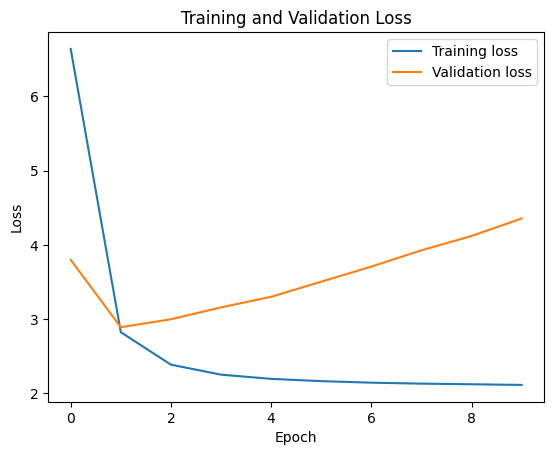

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load the dataset
dataset_path = '/content/drive/My Drive/IR_Project/transformed_workout_plan.csv'
df = pd.read_csv(dataset_path)

# Assuming exercises are in columns '1' through '7' and we fill missing values with -1 (placeholder for no exercise)
exercise_columns = ['1', '2', '3', '4', '5', '6', '7']
df[exercise_columns] = df[exercise_columns].fillna(-1).astype(int)

# Preparing sequences and labels
sequences = df[exercise_columns].values
# For simplicity, let's predict the next exercise based on the previous ones in the same workout
X = sequences[:, :-1]
y = sequences[:, -1]

# One-hot encode the labels for a classification setup
num_classes = 3001  # Assuming 3000 unique exercises + 1 for placeholder
y = to_categorical(y, num_classes=num_classes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=num_classes, output_dim=64, mask_zero=True),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



**Nutrition Based on Recommended Workout**





In [ ]:
import pandas as pd

# Replace 'path_to_your_dataset.csv' with the actual path to your CSV file
dataset = '/content/drive/My Drive/IR_Project/nutrition.csv'
IR_nutrition_data = pd.read_csv(dataset)

# Now, you can use IR_nutrition_data with the find_matching_recipes function


BMI, age, sex, and goal (Maintenance, Gain Muscle, Lose Weight)

In [ ]:
def get_user_inputs():
    print("Please enter your nutritional targets and tolerance levels.")

    # Nutritional goals
    targets = {
        'Carbohydrates': float(input("Target carbohydrates (g): ")),
        'Energy': float(input("Target energy (calories): ")),
        'Protein': float(input("Target protein (g): ")),
        'Fats': float(input("Target fats (g): "))
    }

    # Tolerance levels
    tolerance = {
        'Carbohydrates': float(input("Tolerance for carbohydrates (g): ")),
        'Energy': float(input("Tolerance for energy (calories): ")),
        'Protein': float(input("Tolerance for protein (g): ")),
        'Fats': float(input("Tolerance for fats (g): "))
    }

    # Dietary preference
    dietary_preference = input("Dietary preference (vegan, pescetarian, lacto_vegetarian, non_vegetarian): ")

    return targets, tolerance, dietary_preference

def find_matching_recipes(dataset, targets, tolerance, dietary_preference):
    """
    Searches for recipes matching the user's nutritional goals and dietary preference, sorted by closeness.

    :param dataset: DataFrame containing the recipe data.
    :param targets: Dict with keys for target nutritional values.
    :param tolerance: Dict with the same keys as targets for tolerance levels.
    :param dietary_preference: String indicating dietary preference.

    :return: DataFrame with matching recipes, sorted by closeness to nutritional goals.
    """
    # Filter based on dietary preference
    dietary_column = {
        'vegan': 'vegan',
        'pescetarian': 'pescetarian',
        'lacto_vegetarian': 'lacto_vegetarian',
        'non_vegetarian': 'non_vegetarian'
    }.get(dietary_preference)

    if dietary_column is None:
        raise ValueError("Invalid dietary preference")

    filtered_dataset = dataset[dataset[dietary_column] == 1].copy()

    # Calculate differences and total difference score
    total_diff_score = 0
    for nutrient in ['Carbohydrates', 'Energy', 'Protein', 'Fats']:
        nutrient_diff = abs(filtered_dataset[nutrient] - targets[nutrient]) / tolerance[nutrient]
        filtered_dataset[nutrient + '_diff'] = nutrient_diff
        total_diff_score += nutrient_diff

    filtered_dataset['total_diff_score'] = filtered_dataset[['Carbohydrates_diff', 'Energy_diff', 'Protein_diff', 'Fats_diff']].sum(axis=1)

    # Sort by total difference score (lower scores are closer matches)
    sorted_dataset = filtered_dataset.sort_values(by='total_diff_score')

    # Optionally, remove the diff columns before returning
    return_columns = ['Recipe_title', 'url', 'Carbohydrates', 'Energy', 'Protein', 'Fats', 'total_diff_score'] + [col for col in dataset.columns if col.startswith('vegan') or col.startswith('pesc') or col.startswith('lacto') or col.startswith('non')]
    return sorted_dataset[return_columns]

# Remember to replace `dataset` with your actual DataFrame variable when using this function.

# Collect user inputs
targets, tolerance, dietary_preference = get_user_inputs()

# Find matching recipes
matching_recipes = find_matching_recipes(IR_nutrition_data, targets, tolerance, dietary_preference)

# Display the results
print(matching_recipes)


Please enter your nutritional targets and tolerance levels.
Target carbohydrates (g): 15
Target energy (calories): 682
Target protein (g): 4
Target fats (g): 70
Tolerance for carbohydrates (g): 10
Tolerance for energy (calories): 10
Tolerance for protein (g): 10
Tolerance for fats (g): 10
Dietary preference (vegan, pescetarian, lacto_vegetarian, non_vegetarian): non_vegetarian
                                       Recipe_title  \
0     Lamb Chops in Lemongrass Ginger Coconut Sauce   
587                     Tart and Tangy Potato Salad   
308                         Bobbak's Persian Cookoo   
107              Brinjal (Eggplant) in Coconut Milk   
30                       Tuna, Canary Islands Style   
...                                             ...   
1937                                 Tequila Muppet   
1941                                   Saffron Rice   
1949     Authentic German Black Bread (Schwarzbrot)   
1340                         Lemony Chicken Piccata   
1883           

In [ ]:
import pandas as pd

# Load the dataset
dataset_path = '/content/drive/My Drive/IR_Project/nutrition.csv'
IR_nutrition_data = pd.read_csv(dataset_path)

def calculate_bmr(weight_kg, height_cm, age, sex):
    if sex.lower() == 'male':
        bmr = 88.362 + (13.397 * weight_kg) + (4.799 * height_cm) - (5.677 * age)
    else:
        bmr = 447.593 + (9.247 * weight_kg) + (3.098 * height_cm) - (4.330 * age)
    return bmr

def estimate_daily_caloric_needs(bmr, goal):
    if goal.lower() == 'gain muscle':
        caloric_needs = bmr * 1.1
    elif goal.lower() == 'lose weight':
        caloric_needs = bmr * 0.8
    else:  # Maintenance
        caloric_needs = bmr
    return caloric_needs

def find_matching_recipes(caloric_needs, goal):
    # Adjust the selection of recipes based on the goal
    if goal.lower() == 'gain muscle':
        # Prioritize high protein and higher calorie recipes for muscle gain
        suitable_recipes = IR_nutrition_data.sort_values(by=['Protein', 'Energy'], ascending=[False, False])
    elif goal.lower() == 'lose weight':
        # For weight loss, prioritize lower fat and lower calorie recipes
        suitable_recipes = IR_nutrition_data.sort_values(by=['Fats', 'Energy'], ascending=[True, True])
    else:  # Maintenance
        # For maintenance, no strict sorting, just close to caloric needs
        suitable_recipes = IR_nutrition_data.iloc[(IR_nutrition_data['Energy']-caloric_needs).abs().argsort()]

    # Return top 5 recipes that match the criteria
    return suitable_recipes[['Recipe_title', 'url', 'Energy', 'Protein', 'Fats']].head(5)

# Dynamic user inputs
user_weight_kg = float(input("Please Enter Your Weight (Kg): "))
user_height_cm = float(input("Please Enter Your Height (Cm): "))
user_age = int(input("Please Enter Your Age (Years)): "))
user_sex = input("Please Enter Your Sex (male/female): ").strip().lower()
user_goal = input("Please Enter Your Goal (gain muscle, lose weight, maintenance)): ").strip().lower()

# Calculate BMR
user_bmr = calculate_bmr(user_weight_kg, user_height_cm, user_age, user_sex)

# Estimate daily caloric needs based on BMR and goal
caloric_needs = estimate_daily_caloric_needs(user_bmr, user_goal)

# Find matching recipes
matching_recipes = find_matching_recipes(caloric_needs, user_goal)
print(matching_recipes)


Please Enter Your Weight (Kg): 55
Please Enter Your Height (Cm): 159
Please Enter Your Age (Years)): 20
Please Enter Your Sex (male/female): Female
Please Enter Your Goal (gain muscle, lose weight, maintenance)): maintenance
                                   Recipe_title  \
225                            Shortcut Lasagna   
287               Microwaved Scalloped Potatoes   
60   Cereal Bircher-Benner Style (Birchermusli)   
545                  Manestra - Poor Greek Soup   
103                     Angie's Polenta Lasagna   

                                                   url    Energy  Protein  \
225  http://www.geniuskitchen.com/recipe/shortcut-l...  899.6855  54.9535   
287  http://www.geniuskitchen.com/recipe/microwaved...  899.6124  23.0333   
60   http://www.geniuskitchen.com/recipe/cereal-bir...  898.3300  34.7450   
545  http://www.geniuskitchen.com/recipe/manestra-p...  898.3214  17.3212   
103  http://allrecipes.com/recipe/218035/angies-pol...  898.1140  88.0877   

     